# Header Import

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import names
from nltk.stem import WordNetLemmatizer

import glob
import os
import numpy as np

# Data Load

In [2]:
file_path = 'enron1/ham/0007.1999-12-14.farmer.ham.txt'
with open(file_path, 'r') as infile:
    ham_sample = infile.read()
print(ham_sample)

file_path = 'enron1/spam/0058.2003-12-21.GP.spam.txt'
with open(file_path, 'r') as infile:
    spam_sample = infile.read()
print(spam_sample)

cv = CountVectorizer(stop_words="english", max_features=500)

emails, labels = [], []

file_path = 'enron1/spam/'
for filename in glob.glob(os.path.join(file_path, '*.txt')):
    with open(filename, 'r', encoding = "ISO-8859-1") as infile:
        emails.append(infile.read())
        labels.append(1)

file_path = 'enron1/ham/'
for filename in glob.glob(os.path.join(file_path, '*.txt')):
    with open(filename, 'r', encoding = "ISO-8859-1") as infile:
        emails.append(infile.read())
        labels.append(0)

Subject: mcmullen gas for 11 / 99
jackie ,
since the inlet to 3 river plant is shut in on 10 / 19 / 99 ( the last day of
flow ) :
at what meter is the mcmullen gas being diverted to ?
at what meter is hpl buying the residue gas ? ( this is the gas from teco ,
vastar , vintage , tejones , and swift )
i still see active deals at meter 3405 in path manager for teco , vastar ,
vintage , tejones , and swift
i also see gas scheduled in pops at meter 3404 and 3405 .
please advice . we need to resolve this as soon as possible so settlement
can send out payments .
thanks
Subject: stacey automated system generating 8 k per week parallelogram
people are
getting rich using this system ! now it ' s your
turn !
we ' ve
cracked the code and will show you . . . .
this is the
only system that does everything for you , so you can make
money
. . . . . . . .
because your
success is . . . completely automated !
let me show
you how !
click
here
to opt out click here % random _ text



# Clean Data

In [3]:
def letters_only(astr):
    return astr.isalpha()


all_names = set(names.words())
lemmatizer = WordNetLemmatizer()


def clean_text(docs):
    cleaned_docs = []
    for doc in docs:
        cleaned_docs.append(' '.join([lemmatizer.lemmatize(word.lower())
                                      for word in doc.split()
                                      if letters_only(word)
                                      and word not in all_names]))
    return cleaned_docs

In [4]:
cleaned_emails = clean_text(emails)
term_docs = cv.fit_transform(cleaned_emails)
print(term_docs [0])

feature_mapping = cv.vocabulary
feature_names = cv.get_feature_names()

  (0, 249)	3
  (0, 251)	1
  (0, 99)	1
  (0, 226)	1
  (0, 173)	1
  (0, 455)	2
  (0, 285)	1
  (0, 398)	2
  (0, 477)	1
  (0, 91)	1
  (0, 181)	1
  (0, 154)	1
  (0, 445)	1
  (0, 82)	1
  (0, 9)	1
  (0, 238)	1
  (0, 71)	1
  (0, 197)	2
  (0, 491)	2
  (0, 70)	1


/Users/user/miniforge3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# Setting Probability Function

In [5]:

def get_label_index(labels):
    from collections import defaultdict
    label_index = defaultdict(list)
    for index, label in enumerate(labels):
        label_index[label].append(index)
    return label_index


def get_prior(label_index):
    """ Compute prior based on training samples
    Args:
        label_index (grouped sample indices by class)
    Returns:
        dictionary, with class label as key, corresponding prior as the value
    """
    prior = {label: len(index) for label, index in label_index.items()}
    total_count = sum(prior.values())
    for label in prior:
        prior[label] /= float(total_count)
    return prior


def get_likelihood(term_document_matrix, label_index, smoothing=0):
    """ Compute likelihood based on training samples
    Args:
        term_document_matrix (sparse matrix)
        label_index (grouped sample indices by class)
        smoothing (integer, additive Laplace smoothing parameter)
    Returns:
        dictionary, with class as key, corresponding conditional probability P(feature|class) vector as value
    """
    likelihood = {}
    for label, index in label_index.items():
        likelihood[label] = term_document_matrix[index, :].sum(axis=0) + smoothing
        likelihood[label] = np.asarray(likelihood[label])[0]
        total_count = likelihood[label].sum()
        likelihood[label] = likelihood[label] / float(total_count)
    return likelihood

def get_posterior(term_document_matrix, prior, likelihood):
    """ Compute posterior of testing samples, based on prior and likelihood
    Args:
        term_document_matrix (sparse matrix)
        prior (dictionary, with class label as key, corresponding prior as the value)
        likelihood (dictionary, with class label as key, corresponding conditional probability vector as value)
    Returns:
        dictionary, with class label as key, corresponding posterior as value
    """
    num_docs = term_document_matrix.shape[0]
    posteriors = []
    for i in range(num_docs):
        # posterior is proportional to prior * likelihood
        # = exp(log(prior * likelihood))
        # = exp(log(prior) + log(likelihood))
        posterior = {key: np.log(prior_label) for key, prior_label in prior.items()}
        for label, likelihood_label in likelihood.items():
            term_document_vector = term_document_matrix.getrow(i)
            counts = term_document_vector.data
            indices = term_document_vector.indices
            for count, index in zip(counts, indices):
                posterior[label] += np.log(likelihood_label[index]) * count
        # exp(-1000):exp(-999) will cause zero division error,
        # however it equates to exp(0):exp(1)
        min_log_posterior = min(posterior.values())
        for label in posterior:
            try:
                posterior[label] = np.exp(posterior[label] - min_log_posterior)
            except:
                # if one's log value is excessively large, assign it infinity
                posterior[label] = float('inf')
        # normalize so that all sums up to 1
        sum_posterior = sum(posterior.values())
        for label in posterior:
            if posterior[label] == float('inf'):
                posterior[label] = 1.0
            else:
                posterior[label] /= sum_posterior
        posteriors.append(posterior.copy())
    return posteriors

In [6]:
feature_names[:5]

['able', 'access', 'account', 'accounting', 'act']

# get likelihood and get posterior

In [9]:
label_index = get_label_index(labels)
prior = get_prior(label_index)

smoothing = 1
likelihood = get_likelihood(term_docs, label_index, smoothing)

In [10]:

emails_test = [
    '''Subject: flat screens
    hello ,
    please call or contact regarding the other flat screens requested .
    trisha tlapek - eb 3132 b
    michael sergeev - eb 3132 a
    also the sun blocker that was taken away from eb 3131 a .
    trisha should two monitors also michael .
    thanks
    kevin moore''',
    '''Subject: having problems in bed ? we can help !
    cialis allows men to enjoy a fully normal sex life without having to plan the sexual act .
    if we let things terrify us , life will not be worth living .
    brevity is the soul of lingerie .
    suspicion always haunts the guilty mind .''',
]

cleaned_test = clean_text(emails_test)
term_docs_test = cv.transform(cleaned_test)
posterior = get_posterior(term_docs_test, prior, likelihood)
print(posterior)

[{1: 0.0032745671008376, 0: 0.9967254328991624}, {1: 0.9999984725538845, 0: 1.5274461154428757e-06}]


# model traning

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(cleaned_emails, labels, test_size=0.33, random_state=42)

len(X_train), len(Y_train)
len(X_test), len(Y_test)

term_docs_train = cv.fit_transform(X_train)
label_index = get_label_index(Y_train)
prior = get_prior(label_index)
likelihood = get_likelihood(term_docs_train, label_index, smoothing)

term_docs_test = cv.transform(X_test)
posterior = get_posterior(term_docs_test, prior, likelihood)

correct = 0.0
for pred, actual in zip(posterior, Y_test):
    if actual == 1:
        if pred[1] >= 0.5:
            correct += 1
    elif pred[0] > 0.5:
        correct += 1

/var/folders/mw/qkr8ld2570nfz73rl91f5m300000gn/T/ipykernel_34495/3592782954.py:67: RuntimeWarning: overflow encountered in exp
  posterior[label] = np.exp(posterior[label] - min_log_posterior)


In [12]:
print('The accuracy on {0} testing samples is: {1:.1f}%'.format(len(Y_test), correct/len(Y_test)*100))

The accuracy on 1707 testing samples is: 91.3%


# model traning

In [13]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(alpha=1.0, fit_prior=True)
clf.fit(term_docs_train, Y_train)
prediction_prob = clf.predict_proba(term_docs_test)
prediction_prob[0:10]
prediction = clf.predict(term_docs_test)
prediction[:10]
accuracy = clf.score(term_docs_test, Y_test)
print('The accuracy using MultinomialNB is: {0:.1f}%'.format(accuracy*100))

The accuracy using MultinomialNB is: 91.3%


# metric

In [14]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, prediction, labels=[0, 1])

from sklearn.metrics import precision_score, recall_score, f1_score
precision_score(Y_test, prediction, pos_label=1)
recall_score(Y_test, prediction, pos_label=1)
f1_score(Y_test, prediction, pos_label=1)

f1_score(Y_test, prediction, pos_label=0)

from sklearn.metrics import classification_report
report = classification_report(Y_test, prediction)
print(report)




pos_prob = prediction_prob[:, 1]
thresholds = np.arange(0.0, 1.2, 0.1)
true_pos, false_pos = [0]*len(thresholds), [0]*len(thresholds)
for pred, y in zip(pos_prob, Y_test):
    for i, threshold in enumerate(thresholds):
        if pred >= threshold:
            if y == 1:
                true_pos[i] += 1
            else:
                false_pos[i] += 1
        else:
            break

true_pos_rate = [tp / 516.0 for tp in true_pos]
false_pos_rate = [fp / 1191.0 for fp in false_pos]

              precision    recall  f1-score   support

           0       0.95      0.92      0.94      1191
           1       0.83      0.90      0.86       516

    accuracy                           0.91      1707
   macro avg       0.89      0.91      0.90      1707
weighted avg       0.92      0.91      0.91      1707



# visualize

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


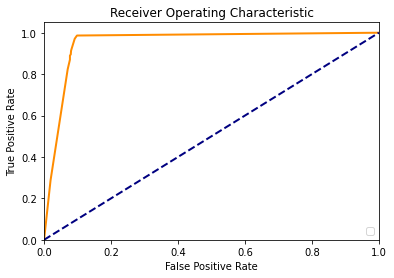

0.9585586992885922

In [15]:
import matplotlib.pyplot as plt
plt.figure()
lw = 2
plt.plot(false_pos_rate, true_pos_rate, color='darkorange',
         lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

from sklearn.metrics import roc_auc_score
roc_auc_score(Y_test, pos_prob)

# k-fold

In [16]:
from sklearn.model_selection import StratifiedKFold
k = 10
k_fold = StratifiedKFold(n_splits=k)
# convert to numpy array for more efficient slicing
cleaned_emails_np = np.array(cleaned_emails)
labels_np = np.array(labels)

max_features_option = [2000, 4000, 8000]
smoothing_factor_option = [0.5, 1.0, 1.5, 2.0]
fit_prior_option = [True, False]
auc_record = {}

for train_indices, test_indices in k_fold.split(cleaned_emails, labels):
    X_train, X_test = cleaned_emails_np[train_indices], cleaned_emails_np[test_indices]
    Y_train, Y_test = labels_np[train_indices], labels_np[test_indices]
    for max_features in max_features_option:
        if max_features not in auc_record:
            auc_record[max_features] = {}
        cv = CountVectorizer(stop_words="english", max_features=max_features)
        term_docs_train = cv.fit_transform(X_train)
        term_docs_test = cv.transform(X_test)
        for smoothing_factor in smoothing_factor_option:
            if smoothing_factor not in auc_record[max_features]:
                auc_record[max_features][smoothing_factor] = {}
            for fit_prior in fit_prior_option:
                clf = MultinomialNB(alpha=smoothing_factor, fit_prior=fit_prior)
                clf.fit(term_docs_train, Y_train)
                prediction_prob = clf.predict_proba(term_docs_test)
                pos_prob = prediction_prob[:, 1]
                auc = roc_auc_score(Y_test, pos_prob)
                auc_record[max_features][smoothing_factor][fit_prior] = auc + auc_record[max_features][smoothing_factor].get(fit_prior, 0.0)

print(auc_record)

print('max features  smoothing  fit prior  auc')
for max_features, max_feature_record in auc_record.items():
    for smoothing, smoothing_record in max_feature_record.items():
        for fit_prior, auc in smoothing_record.items():
            print('       {0}      {1}      {2}    {3:.4f}'.format(max_features, smoothing, fit_prior, auc/k))

{2000: {0.5: {True: 9.775015623148915, False: 9.773452987402758}, 1.0: {True: 9.759499664336769, False: 9.757092218536508}, 1.5: {True: 9.746553133514986, False: 9.746534918848479}, 2.0: {True: 9.737250375153023, False: 9.737040733720333}}, 4000: {0.5: {True: 9.842754561070963, False: 9.842409148797534}, 1.0: {True: 9.826806213718754, False: 9.826471932630415}, 1.5: {True: 9.817602327923233, False: 9.816757098290092}, 2.0: {True: 9.809858577182798, False: 9.809567586778819}}, 8000: {0.5: {True: 9.884097288038543, False: 9.883672698732378}, 1.0: {True: 9.873354731864314, False: 9.874089390080163}, 1.5: {True: 9.868979633139832, False: 9.868860793547368}, 2.0: {True: 9.865693983730207, False: 9.866238227105795}}}
max features  smoothing  fit prior  auc
       2000      0.5      True    0.9775
       2000      0.5      False    0.9773
       2000      1.0      True    0.9759
       2000      1.0      False    0.9757
       2000      1.5      True    0.9747
       2000      1.5      False 